In [1]:
from PyPDF2 import PdfReader
import os
import pandas as pd
pd.set_option('display.max_colwidth', 100)
import glob
import numpy as np

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
def get_pdfs_in_directory(directory_path):
    # Use glob to get all PDF files in the directory
    pdf_files = glob.glob(os.path.join(directory_path, '*.pdf'))
    return pdf_files
pdf_not_relevant = get_pdfs_in_directory('test_data/not_relevant')
pdf_relevant = get_pdfs_in_directory('test_data/relevant')

In [3]:
def text_extract(reader):
    doc_text = ""
    num_pages = len(reader.pages)
    for i in range(num_pages):
        page_text = reader.pages[i].extract_text() + " "
        doc_text += page_text
    return doc_text

def get_info(path,relevant):
    with open(path, 'rb') as f:
        pdf = PdfReader(f)
        info = pdf.metadata
        author = info.author if '/Author' in info else None
        title = info.title if '/Title' in info else None
        subject = info.subject if '/Subject' in info else None
        keywords = info['/Keywords'] if '/Keywords' in info else None
        number_of_pages = len(pdf.pages)
        text = text_extract(pdf)
        relevance = 1 if relevant else 0
        doc_path = path
    return [path, author, title, subject, keywords, number_of_pages, text, relevance]

In [4]:
all_info = []
for pdf in pdf_not_relevant:
	all_info.append(get_info(pdf,relevant = False))
for pdf in pdf_relevant:
	all_info.append(get_info(pdf,relevant = True))
harvest_nlp = pd.DataFrame(all_info,columns = ['doc_path','author','title','subject','keywords','num_pages','text','is_relevant'])

In [5]:
harvest_nlp.head()

,doc_path,author,title,subject,keywords,num_pages,text,is_relevant
0,test_data/not_relevant/PDF_antenatal-screening-for-HIV-hepB-syph-rubella-tech-report-lit-review-...,ECDC,"Effectiveness and cost-effectiveness of antenatal screening for HIV, hepatitis B, syphilis and r...",None,None,37,"TECHNICAL REPORT\nEffectiveness and cost- \neffectiveness of antenatal screening \nfor HIV, he...",0
1,test_data/not_relevant/PDF_100720_implementing_dublic_declaration_hiv_aids_2010_progress_report.pdf,None,None,None,None,45,SPECIAL REPORT\nImplementing the \nDublin Declaration on \nPartnership to Fight HIV/AIDS \nin E...,0
2,test_data/not_relevant/PDF_dublin-declaration-sex-workers-2014.pdf,None,None,None,None,15,SPECIAL REPORT\nThematic report: \nSex workers \nMonitoring implementation of the Dublin Decla...,0
3,test_data/not_relevant/PDF_20121130-Risk-Assessment-HIV-in-Greece.pdf,None,None,None,None,36,TECHNICAL REPORT\nRisk assessment on HIV in Greece\nwww.ecdc.europa.eu \n \n \n \n \n \n ...,0
4,test_data/not_relevant/PDF_CHLAM_AER_2022_Report.pdf,ECDC,Chlamydia - Annual epidemiological report,"Chlamydia, surveillance, monitoring","Chlamydia, surveillance, monitoring",9,\nSuggested citation: European Centre for Disease Prevention and Control . Chlamydia . In: ECDC...,0


## Remove/Replace Nulls

In [6]:
harvest_nlp.isna().sum()

doc_path        0
author         43
title          48
subject        56
keywords       50
num_pages       0
text            0
is_relevant     0
dtype: int64

In [7]:
len(harvest_nlp)

72

In [8]:
harvest_nlp.columns

Index(['doc_path', 'author', 'title', 'subject', 'keywords', 'num_pages',
       'text', 'is_relevant'],
      dtype='object')

In [9]:
#replace empty strings with Unknown
harvest_nlp.replace('','Unknown',inplace=True)
harvest_nlp.replace(' ','Unknown',inplace=True)

#fill na values, drop ones that aren't necessary (only dropped one since there isn't too much data)
harvest_nlp.fillna({'author': 'Unknown',
						'title': 'Unknown',
						'subject': 'Unknown',
						'keywords': 'Unknown',
						},inplace=True)

In [10]:
harvest_nlp.isna().sum()

doc_path       0
author         0
title          0
subject        0
keywords       0
num_pages      0
text           0
is_relevant    0
dtype: int64

In [11]:
harvest_nlp

,doc_path,author,title,subject,keywords,num_pages,text,is_relevant
0,test_data/not_relevant/PDF_antenatal-screening-for-HIV-hepB-syph-rubella-tech-report-lit-review-...,ECDC,"Effectiveness and cost-effectiveness of antenatal screening for HIV, hepatitis B, syphilis and r...",Unknown,Unknown,37,"TECHNICAL REPORT\nEffectiveness and cost- \neffectiveness of antenatal screening \nfor HIV, he...",0
1,test_data/not_relevant/PDF_100720_implementing_dublic_declaration_hiv_aids_2010_progress_report.pdf,Unknown,Unknown,Unknown,Unknown,45,SPECIAL REPORT\nImplementing the \nDublin Declaration on \nPartnership to Fight HIV/AIDS \nin E...,0
2,test_data/not_relevant/PDF_dublin-declaration-sex-workers-2014.pdf,Unknown,Unknown,Unknown,Unknown,15,SPECIAL REPORT\nThematic report: \nSex workers \nMonitoring implementation of the Dublin Decla...,0
3,test_data/not_relevant/PDF_20121130-Risk-Assessment-HIV-in-Greece.pdf,Unknown,Unknown,Unknown,Unknown,36,TECHNICAL REPORT\nRisk assessment on HIV in Greece\nwww.ecdc.europa.eu \n \n \n \n \n \n ...,0
4,test_data/not_relevant/PDF_CHLAM_AER_2022_Report.pdf,ECDC,Chlamydia - Annual epidemiological report,"Chlamydia, surveillance, monitoring","Chlamydia, surveillance, monitoring",9,\nSuggested citation: European Centre for Disease Prevention and Control . Chlamydia . In: ECDC...,0
...,...,...,...,...,...,...,...,...
67,test_data/relevant/PDF_DD_HIV_TestingBrief_May2022-revised-final.pdf,ECDC,Dublin Declaration evidence brief: HIV testing in Europe and Central Asia,"Dublin Declaration, HIV testing",HIV testing; Dublin Declaration; partnership to fight HIV/AIDS; Europe; EU; EEA; Central Asia; E...,11,Suggested citation: HIV testing in Europe and Central Asia . Monitoring implementation of the Du...,1
68,test_data/relevant/PDF_AERChlamydia2021.pdf,Fabrice Donguy,AER_template.docx,Unknown,Unknown,8,\n \n \nSuggested citation: European Centre for Disease Prevention and Control. Chlamydia . In:...,1
69,test_data/relevant/PDF_communicable-disease-threats-report-week-10-2024.pdf,Rumila Edward,2024-WCP-0017 Draft.docx,Not specified,Communicable disease threats report,13,"\n \nEuropean Centre for Disease Prevention and Control, Solna, Sweden \nwww.ecdc.europa.eu \...",1
70,test_data/relevant/PDF_CoC_HIV_0.pdf,ECDC,Continuum of HIV care: 2022 progress report,HIV,HIV; continuum of HIV care; continuum of care; men who have sex with men; MSM; PWID; people who ...,69,SPECIAL REPORT\nContinuum of HIV care\n \nMonitoring implementation of the Dublin \nDeclaration ...,1


## Preprocessing/Cleaning

In [12]:
STOPWORDS = stopwords.words('english')
from spacy.lang.en import STOP_WORDS
lemmatizer = WordNetLemmatizer()

def clean_text(text):

    text = text.lower()

    patterns = {
        ### UNDERSTAND CONTEXT FIRST BEFORE CHANGING, HELPS TO MAKE MORE INFORMED DECISIONS
        #remove \n and \r and \t
        r'\n|\r|\t': ' ',

        #replaces 4-digit numbers starting with 1 or 2 with "year"
        r'\b[12]\d{3}\b':'year',
        
        }
    for pattern, replacement in patterns.items():
        text = re.sub(pattern, replacement, text)

    # remove punctuations
    puncs = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''
    for p in puncs:
        text = text.replace(p,'') 
    
    # remove stopwords and make sure word length is greater than 2
    text = [word.lower() for word in text.split() if word.lower() not in STOP_WORDS and len(word)>1]

    text = [lemmatizer.lemmatize(word) for word in text]

    text = " ".join(text)

    return text

harvest_nlp['text_modified'] = harvest_nlp['text'].apply(lambda x: clean_text(x))

In [13]:
from collections import Counter

all_words = ' '.join(harvest_nlp['text_modified']).split()
word_counts = Counter(all_words)

def remove_low_high_occuring_words(text,low,high):
	words = text.split()
	new_text = " ".join(word for word in words if word_counts[word]>low and word_counts[word]<high)
	return new_text

#play around with this
harvest_nlp['text_modified'] = harvest_nlp['text_modified'].apply(lambda text: remove_low_high_occuring_words(text,100,500))

In [14]:
#test if the remove_low_high_occuring_words function works

all_words = ' '.join(harvest_nlp['text_modified']).split()
word_counts = Counter(all_words)
print(sum(1 for value in word_counts.values() if value == 99))

0


## Check Prior to 2018

In [15]:
#find whether before 2008 based on number of occurences

def find_years(text):
	years_found = re.findall(r'\b(?:19|20)\d{2}\b',text)
	return years_found

harvest_nlp['years'] = harvest_nlp['text'].apply(lambda x: find_years(x))

harvest_nlp['num_before_2018'] = harvest_nlp['years'].apply(lambda years: sum([1 for year in years if int(year)<2018]))
harvest_nlp['num_2018_and_on'] = harvest_nlp['years'].apply(lambda years: sum([1 for year in years if int(year)>=2018]))

harvest_nlp['probably_before_2018'] = harvest_nlp.apply(lambda row: 1 if row['num_before_2018']>row['num_2018_and_on'] else 0,axis=1)

In [16]:
harvest_nlp

,doc_path,author,title,subject,keywords,num_pages,text,is_relevant,text_modified,years,num_before_2018,num_2018_and_on,probably_before_2018
0,test_data/not_relevant/PDF_antenatal-screening-for-HIV-hepB-syph-rubella-tech-report-lit-review-...,ECDC,"Effectiveness and cost-effectiveness of antenatal screening for HIV, hepatitis B, syphilis and r...",Unknown,Unknown,37,"TECHNICAL REPORT\nEffectiveness and cost- \neffectiveness of antenatal screening \nfor HIV, he...",0,susceptibility literature susceptibility literature ii institute suggested susceptibility stockh...,"[2012, 2017, 2017, 2011, 2014, 2011, 2011, 1990, 2011, 2012, 2012, 2014, 2000, 2014, 2011, 2012,...",240,1,1
1,test_data/not_relevant/PDF_100720_implementing_dublic_declaration_hiv_aids_2010_progress_report.pdf,Unknown,Unknown,Unknown,Unknown,45,SPECIAL REPORT\nImplementing the \nDublin Declaration on \nPartnership to Fight HIV/AIDS \nin E...,0,implementing partnership fight summary implementing partnership fight summary partnership fight ...,"[2010, 2010, 2010, 2009, 2010, 2010, 2010, 2010, 2010, 2010, 2004, 2009, 2013, 2005, 2007, 2002,...",165,0,1
2,test_data/not_relevant/PDF_dublin-declaration-sex-workers-2014.pdf,Unknown,Unknown,Unknown,Unknown,15,SPECIAL REPORT\nThematic report: \nSex workers \nMonitoring implementation of the Dublin Decla...,0,thematic partnership fight thematic partnership fight ii series thematic submitted partnership f...,"[2014, 2014, 2014, 2013, 2014, 2015, 2015, 2015, 2014, 2014, 2011, 2013, 2011, 2013, 2011, 2013,...",48,0,1
3,test_data/not_relevant/PDF_20121130-Risk-Assessment-HIV-in-Greece.pdf,Unknown,Unknown,Unknown,Unknown,36,TECHNICAL REPORT\nRisk assessment on HIV in Greece\nwww.ecdc.europa.eu \n \n \n \n \n \n ...,0,assessment assessment ii tion van stis like authority particular center organisation assessment ...,"[2012, 2012, 2012, 2012, 2012, 2012, 2007, 2012, 2011, 2012, 2011, 2011, 2001, 2010, 2011, 2011,...",414,0,1
4,test_data/not_relevant/PDF_CHLAM_AER_2022_Report.pdf,ECDC,Chlamydia - Annual epidemiological report,"Chlamydia, surveillance, monitoring","Chlamydia, surveillance, monitoring",9,\nSuggested citation: European Centre for Disease Prevention and Control . Chlamydia . In: ECDC...,0,suggested chlamydia annual stockholm stockholm march fact 216 chlamydia notification 88 notifica...,"[2022, 2024, 2024, 2022, 2021, 2018, 2019, 2020, 2021, 2022, 2022, 2021, 2018, 2022, 2022, 2024,...",25,112,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,test_data/relevant/PDF_DD_HIV_TestingBrief_May2022-revised-final.pdf,ECDC,Dublin Declaration evidence brief: HIV testing in Europe and Central Asia,"Dublin Declaration, HIV testing",HIV testing; Dublin Declaration; partnership to fight HIV/AIDS; Europe; EU; EEA; Central Asia; E...,11,Suggested citation: HIV testing in Europe and Central Asia . Monitoring implementation of the Du...,1,suggested fight stockholm stockholm brief priority largely collected monitor ion liechtenstein o...,"[2021, 2022, 2022, 2021, 2004, 2030, 2016, 2020, 2030, 2021, 2022, 2022, 2020, 2019, 2018, 2017,...",34,55,0
68,test_data/relevant/PDF_AERChlamydia2021.pdf,Fabrice Donguy,AER_template.docx,Unknown,Unknown,8,\n \n \nSuggested citation: European Centre for Disease Prevention and Control. Chlamydia . In:...,1,suggested chlamydia annual epidemiological stockholm stockholm november 201 fact 184 chlamydia n...,"[2021, 2023, 2023, 2021, 2012, 2019, 2020, 2021, 2021, 2023, 2021, 2021, 2019, 2015, 2021, 2012,...",30,82,0
69,test_data/relevant/PDF_communicable-disease-threats-report-week-10-2024.pdf,Rumila Edward,2024-WCP-0017 Draft.docx,Not specified,Communicable disease threats report,13,"\n \nEuropean Centre for Disease Prevention and Control, Solna, Sweden \nwww.ecdc.europa.eu \...",1,week march topic overview virus epidemiology sexually transmitted linked middle syndrome summary...,"[2024, 2022, 2024, 2023, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2024, 2023, 2024, 2023, 2022,...",7,185,0
70,test_

In [17]:
harvest_nlp['text_modified']

0     susceptibility literature susceptibility literature ii institute suggested susceptibility stockh...
1     implementing partnership fight summary implementing partnership fight summary partnership fight ...
2     thematic partnership fight thematic partnership fight ii series thematic submitted partnership f...
3     assessment assessment ii tion van stis like authority particular center organisation assessment ...
4     suggested chlamydia annual stockholm stockholm march fact 216 chlamydia notification 88 notifica...
                                                     ...                                                 
67    suggested fight stockholm stockholm brief priority largely collected monitor ion liechtenstein o...
68    suggested chlamydia annual epidemiological stockholm stockholm november 201 fact 184 chlamydia n...
69    week march topic overview virus epidemiology sexually transmitted linked middle syndrome summary...
70    partnership fight partnership fight ii a

things i need to experiment with
- thresholds for removing low/high occuring words
- feature engineering new features

- modeling tweaks to tfidf
- modeling tweaks to the randomforestmodel

In [18]:
harvest_nlp['author'].unique()

array(['ECDC', 'Unknown', 'Rumila Edward', 'Mapper', 'Uwe Kreisel',
       'jkleine', 'mStraetemans',
       'European Centre for Disease Prevention and Control',
       'Fabrice Donguy'], dtype=object)

## Modeling

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

#feature_columns = [col for col in harvest_nlp.columns if col !='text_modified' and col!='is_relevant']
feature_columns = ['num_pages']

preprocessor = ColumnTransformer(
	transformers=[
		('tfidf',TfidfVectorizer(max_features=3000),"text_modified"),
		('num',StandardScaler(),feature_columns)
    ],
	remainder='drop'
)

pipeline = Pipeline(steps = [
	('preprocessor',preprocessor),
	('classifier',GaussianNB())
])

In [20]:
features = harvest_nlp[['num_pages','text_modified']]
target = harvest_nlp['is_relevant']

X_train, X_test , y_train, y_test = train_test_split(features,target,
													 test_size=0.2,
													 random_state=42,
													 stratify=harvest_nlp['is_relevant'].values)
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('tfidf',
                                                  TfidfVectorizer(max_features=3000),
                                                  'text_modified'),
                                                 ('num', StandardScaler(),
                                                  ['num_pages'])])),
                ('classifier', GaussianNB())])

In [21]:
pipeline.score(X_test,y_test)
y_pred = pipeline.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0])

In [22]:
y_test.values

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [23]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        13
           1       0.50      0.50      0.50         2

    accuracy                           0.87        15
   macro avg       0.71      0.71      0.71        15
weighted avg       0.87      0.87      0.87        15



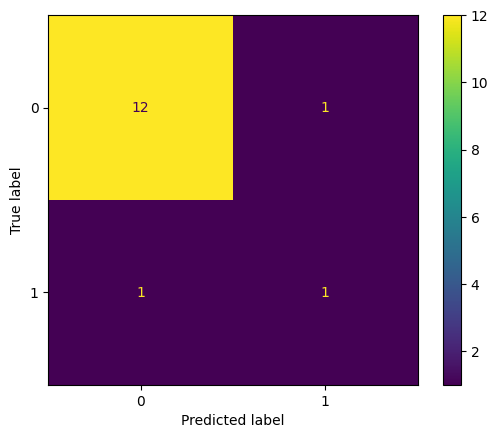

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_pred=y_pred,y_true=y_test)
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


X_train, X_test , y_train, y_test = train_test_split(harvest_nlp['text_modified'].values,harvest_nlp['is_relevant'].values,
													 test_size=0.2,
													 random_state=42,
													 stratify=harvest_nlp['is_relevant'].values)

In [26]:
tfidf_vectorizer = TfidfVectorizer(max_features=3000) #play around with this
tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

In [27]:
from sklearn.model_selection import GridSearchCV

# play around with this too
param_grid = {
	'max_features':[None,"sqrt",0.2],
	'n_jobs': [-1],
	
}
rf=RandomForestClassifier()
grid_search = GridSearchCV(rf, param_grid=param_grid, scoring='f1')  
grid_search.fit(tfidf_train_vectors,y_train)   
print(grid_search.best_params_)

{'max_features': None, 'n_jobs': -1}


In [28]:
y_pred = grid_search.predict(tfidf_test_vectors)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

## Test: Cosine Similarity
- finds the document that is the most similar and assigns it to that label
- works surprisingly well

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

train_size = 0.8
X = harvest_nlp.drop('is_relevant',axis=1)
y = harvest_nlp['is_relevant']

X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=train_size,stratify=y,random_state=42)

train_data = X_train.copy()
train_data['is_relevant'] = y_train

test_data = X_test.copy()
test_data['is_relevant'] = y_test

In [31]:
vectorizer = TfidfVectorizer()
pretrained_vectors = vectorizer.fit_transform(train_data['text_modified'])

predictions = []
test_text = test_data['text_modified']
for text in test_text:
    new_vector = vectorizer.transform([text])
    similarity_scores = cosine_similarity(new_vector,pretrained_vectors)
    most_similar_index = np.argmax(similarity_scores)
    predicted_label = train_data[['text_modified','is_relevant']].iloc[most_similar_index]['is_relevant']
    predictions.append(predicted_label)
    print(f"Highest Similarity Score with a Document in the Training Set: {similarity_scores[0][most_similar_index]:.3f}, Prediction: {'Relevant' if predicted_label==1 else 'Not Relevant'}")


Highest Similarity Score with a Document in the Training Set: 0.259, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.757, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.591, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.483, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.842, Prediction: Relevant
Highest Similarity Score with a Document in the Training Set: 0.662, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.439, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.448, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.651, Prediction: Relevant
Highest Similarity Score with a Document in the Training Set: 0.487, Prediction: Not Relevant
Highest Similarity Score with a Document in the Training Set: 0.728,

In [28]:
predictions

[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0]

In [29]:
test_data['is_relevant'].values

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [32]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_data['is_relevant'].values, predictions)
accuracy

0.9333333333333333

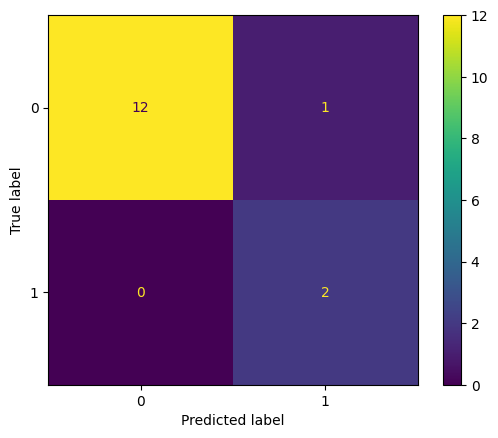

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_pred=predictions,y_true=test_data['is_relevant'].values)
disp = ConfusionMatrixDisplay(cm)
disp.plot()